# 🎬 Global Movie Trends: Een PySpark Analyse

**Doel van dit project:**
In deze notebook analyseren we de wereldwijde filmproductie. We kijken niet alleen naar absolute aantallen, maar correleren dit met populatiedata (films per hoofd van de bevolking) en kwaliteit (IMDb ratings).

**Gebruikte Technologieën:**
We gebruiken **Apache Spark** voor de dataverwerking omdat dit schaalbaar is voor grote datasets. Voor de visualisatie gebruiken we **Seaborn** en **Plotly**.

Hieronder initialiseren we de omgeving en starten we de Spark Sessie.

In [1]:
# 1. Imports & Configuratie
import warnings
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

# PySpark Imports: Essentieel voor dataframe operaties en SQL functies
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, from_json, explode, year, count, avg, desc, 
    regexp_replace, when, expr, lower, trim
)
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

# Configuratie: Warnings onderdrukken voor een schone presentatie
warnings.filterwarnings("ignore")
DATA_PATH = "data/"

# Spark Sessie Starten: Dit is de toegangspoort tot alle Spark functionaliteiten
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GlobalMovieTrends_Final") \
    .getOrCreate()

print("Spark Sessie succesvol geïnitialiseerd.")

Spark Sessie succesvol geïnitialiseerd.


## 1. Data Ingestion (Het laden van de data)

We werken met drie verschillende datasets die we moeten combineren:
1.  **Movies Metadata:** Bevat details over films, genres en productielanden.
2.  **Population Data:** Bevat bevolkingscijfers per land (nodig voor normalisatie).
3.  **IMDb Top 1000:** Een lijst met hooggewaardeerde films (voor de kwaliteitsanalyse).

We gebruiken `inferSchema=True` zodat Spark automatisch herkent wat getallen zijn en wat tekst is.

In [2]:
def load_csv(filename):
    """Hulpfunctie om CSV's in te laden met headers en automatisch schema."""
    path = f"{DATA_PATH}{filename}"
    return spark.read.option("header", True).option("inferSchema", True).csv(path)

# Inladen van de datasets
try:
    movies_metadata = load_csv("movies_dataset/movies_metadata.csv")
    population_by_country = load_csv("population_by_country/population_by_country_2020.csv")
    imdb_top_1000 = load_csv("imdb_top_1000/IMDB top 1000.csv")
    print("Alle datasets succesvol geladen.")
except Exception as e:
    print(f"Fout bij laden: {e}. Controleer het pad.")

Alle datasets succesvol geladen.


## 2. Technische Deep-Dive: RDD Transformaties

Soms is data ongestructureerd of "vies". De kolom `genres` bevat tekst die lijkt op een lijst, maar het is eigenlijk een string.

Hier demonstreren we de kracht van **RDD's (Resilient Distributed Datasets)**. In plaats van standaard SQL, gebruiken we Python functies (`map`, `reduce`) om deze complexe strings te parsen en de meest voorkomende genres te tellen. Dit toont aan dat we ook met ongestructureerde data overweg kunnen.

In [3]:
# Function to parse genre strings using AST (Abstract Syntax Tree)
def parse_genres(row):
    try:
        if not row.genres: return []
        data = ast.literal_eval(row.genres) # Safely evaluate string as list
        return [item['name'] for item in data]
    except:
        return []

# RDD Pipeline: Filter -> Map -> FlatMap -> Map -> ReduceByKey -> Sort
print(f"Processing {movies_metadata.count()} movies using RDDs...")

rdd_genres = movies_metadata.select("genres").rdd \
    .filter(lambda row: row.genres is not None) \
    .map(parse_genres) \
    .flatMap(lambda x: x) \
    .map(lambda genre: (genre, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending=False)

# Display Top 5
print("\nTop 5 Genres (Calculated via RDD):")
for genre, count_val in rdd_genres.take(5):
    print(f"- {genre}: {count_val}")

Processing 45572 movies using RDDs...

Top 5 Genres (Calculated via RDD):
- Drama: 20239
- Comedy: 13123
- Thriller: 7612
- Romance: 6722
- Action: 6581


## 3. Data Transformation (ETL Pipeline)

Dit is de kern van de data engineering. We moeten de datasets opschonen en aan elkaar koppelen.
We voeren drie belangrijke stappen uit:

1.  **JSON Parsing:** De kolom `production_countries` is een JSON-string. Deze "exploderen" we zodat elke film gekoppeld wordt aan een specifiek land.
2.  **Data Cleaning:** De namen van landen komen niet altijd overeen (bijv. "United States" vs "United States of America"). Dit normaliseren we.
3.  **Joining:** We koppelen de films aan de populatiedata via een `INNER JOIN` en zetten de ratings om naar getallen.

In [4]:
# STAP A: Movies opschonen (JSON Landen parsen)
# We vervangen enkele quotes door dubbele voor valide JSON
movies_clean = movies_metadata.withColumn(
    "production_countries", 
    regexp_replace(col("production_countries"), "'", '"')
)

country_schema = ArrayType(StructType([
    StructField("iso_3166_1", StringType()),
    StructField("name", StringType())
]))

# JSON parsen en exploden (1 rij per land per film)
movies_exploded = movies_clean \
    .withColumn("countries_struct", from_json(col("production_countries"), country_schema)) \
    .select(
        col("title"),
        year(col("release_date")).alias("release_year"),
        col("vote_average"),
        explode(col("countries_struct")).alias("country_info")
    ) \
    .select(
        col("title"),
        col("release_year"),
        col("vote_average"),
        col("country_info.iso_3166_1").alias("country_code"),
        col("country_info.name").alias("country_name")
    ) \
    .filter(col("country_code").isNotNull())

# STAP B: Populatie data normaliseren (VS naam fixen)
population_clean = population_by_country \
    .withColumnRenamed("Country (or dependency)", "pop_country_name") \
    .withColumnRenamed("Population (2020)", "population") \
    .withColumn("pop_country_name", 
        when(col("pop_country_name") == "United States", "United States of America")
        .otherwise(col("pop_country_name"))
    )

# STAP C: Joinen & Types casten
# Inner join om films aan populatie te koppelen
df_enriched = movies_exploded.join(
    population_clean,
    movies_exploded.country_name == population_clean.pop_country_name,
    "inner"
)

# Robuuste type-casting (foutieve strings worden null, daarna gefilterd)
df_enriched = df_enriched \
    .withColumn("vote_average", expr("try_cast(vote_average as double)")) \
    .filter(col("vote_average").isNotNull())

print("ETL Voltooid. Schema overzicht:")
df_enriched.printSchema()

ETL Voltooid. Schema overzicht:
root
 |-- title: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- pop_country_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- Yearly Change: string (nullable = true)
 |-- Net Change: integer (nullable = true)
 |-- Density (P/Km²): integer (nullable = true)
 |-- Land Area (Km²): integer (nullable = true)
 |-- Migrants (net): double (nullable = true)
 |-- Fert. Rate: string (nullable = true)
 |-- Med. Age: string (nullable = true)
 |-- Urban Pop %: string (nullable = true)
 |-- World Share: string (nullable = true)



## 4. Analyse: Kwantiteit (Films per Capita)

Nu de data schoon is, beantwoorden we de eerste onderzoeksvraag: **Welk land produceert relatief gezien de meeste films?**

Als we puur naar aantallen kijken, wint de VS altijd. Daarom berekenen we een nieuwe metric: `movies_per_100k` (Aantal films per 100.000 inwoners). We filteren hele kleine filmindustrieën (< 50 films) eruit om uitschieters te voorkomen.

In [5]:
# Aggregeren: Totaal films en gemiddelde rating per land
films_per_country = df_enriched.groupBy("country_name", "country_code", "population") \
    .agg(
        count("title").alias("total_movies"), 
        avg("vote_average").alias("avg_rating")
    )

# Bereken de 'Per Capita' metric
analysis_per_capita = films_per_country \
    .withColumn("movies_per_100k", (col("total_movies") / col("population")) * 100000) \
    .filter(col("total_movies") > 50) \
    .orderBy(desc("movies_per_100k"))

print("Top 10 Landen (Films per 100.000 inwoners):")
analysis_per_capita.show(10)

Top 10 Landen (Films per 100.000 inwoners):
+--------------------+------------+----------+------------+------------------+------------------+
|        country_name|country_code|population|total_movies|        avg_rating|   movies_per_100k|
+--------------------+------------+----------+------------+------------------+------------------+
|             Iceland|          IS|    341628|          64| 6.074999999999999|18.733827438032012|
|          Luxembourg|          LU|    627704|          76| 5.563157894736842| 12.10761760320151|
|           Hong Kong|          HK|   7507523|         521| 6.204030710172744| 6.939705679223361|
|             Finland|          FI|   5542237|         358| 5.259217877094972| 6.459485583167952|
|             Denmark|          DK|   5795780|         361|6.1551246537396125| 6.228669825286675|
|United States of ...|          US| 331341050|       19287| 5.594540363975729| 5.820890589922377|
|      United Kingdom|          GB|  67948282|        3814| 6.017907708442

## 5. Analyse: Kwaliteit (Spark SQL Integratie)

Voor de tweede vraag kijken we naar **kwaliteit**. Welke landen zijn het best vertegenwoordigd in de IMDb Top 1000?

Hier laten we zien dat we naadloos kunnen schakelen tussen DataFrames en **Spark SQL**. 
Omdat titels in de IMDb dataset er anders uitzien (bijv. "1. The Godfather (1972)"), gebruiken we **Regular Expressions (Regex)** om de titels schoon te maken voordat we joinen.

In [6]:
# A. Data voorbereiden (Regex Cleaning voor titels)
# We verwijderen rangnummers zoals "1. " en jaartallen zoals "(1994)"
imdb_clean = imdb_top_1000.select(
    col("Title").alias("raw_title"), 
    col("Rate").alias("imdb_rating")
) \
.withColumn("clean_title", regexp_replace(col("raw_title"), "^[0-9]+\\.\\s", "")) \
.withColumn("clean_title", regexp_replace(col("clean_title"), "\\s\\([0-9]{4}\\)$", "")) \
.withColumn("join_key", lower(trim(col("clean_title"))))

# Join key aanmaken in de hoofd-dataset
df_enriched_join = df_enriched.withColumn("join_key", lower(trim(col("title"))))

# B. Registreren als tijdelijke SQL Views
df_enriched_join.createOrReplaceTempView("movies_view")
imdb_clean.createOrReplaceTempView("imdb_view")

# C. Spark SQL Query uitvoeren
print("Uitvoeren van SQL Query voor Top Films...")
sql_result = spark.sql("""
    SELECT 
        m.country_name, 
        COUNT(m.title) as num_top_movies
    FROM movies_view m
    JOIN imdb_view i ON m.join_key = i.join_key
    GROUP BY m.country_name
    ORDER BY num_top_movies DESC
""")

sql_result.show(10)

Uitvoeren van SQL Query voor Top Films...
+--------------------+--------------+
|        country_name|num_top_movies|
+--------------------+--------------+
|United States of ...|           521|
|      United Kingdom|           129|
|               India|            91|
|              France|            86|
|             Germany|            74|
|               Japan|            55|
|               Italy|            51|
|           Hong Kong|            32|
|         South Korea|            32|
|              Sweden|            27|
+--------------------+--------------+
only showing top 10 rows


## 6. Visualisatie & Dashboarding

Tot slot visualiseren we onze bevindingen.

1.  **Seaborn Barplot:** Toont de absolute leiders in kwaliteit (Top 1000 films).
2.  **Plotly Wereldkaart:** Een interactieve kaart die de filmproductie per hoofd van de bevolking toont. Hier zien we duidelijk dat Europese landen sterk scoren.
3.  **Interactieve Widget:** Een dynamisch dashboard waarmee we zelf kunnen bepalen hoeveel landen we willen zien in de grafiek.

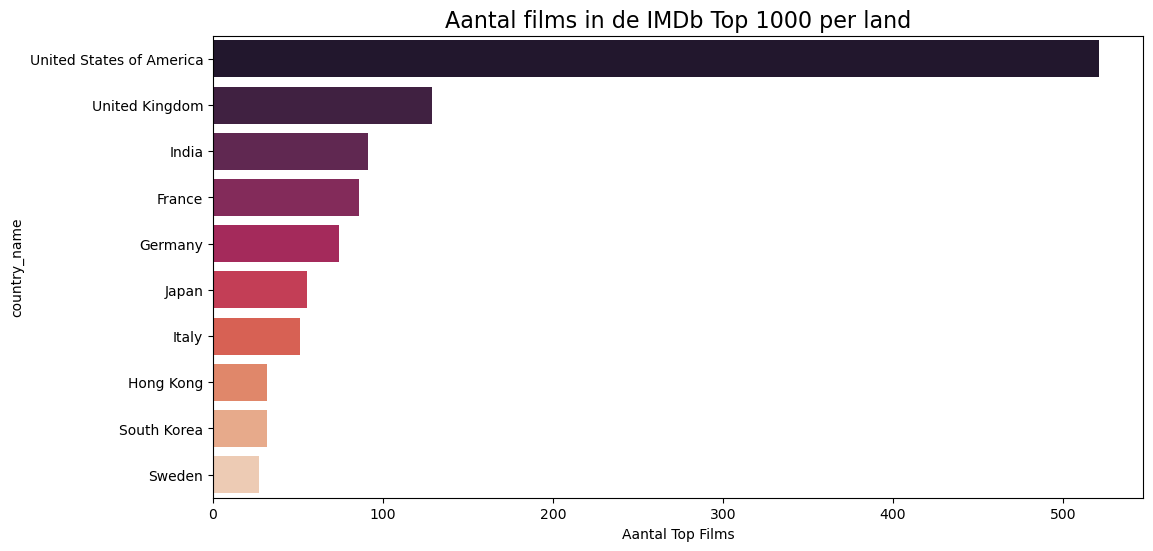


Interactief Dashboard:


interactive(children=(IntSlider(value=10, description='top_n', max=20, min=5), Output()), _dom_classes=('widge…

In [7]:
# 1. Seaborn Barplot (Kwaliteit)
pdf_quality = sql_result.limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=pdf_quality, x="num_top_movies", y="country_name", 
    palette="rocket", hue="country_name", legend=False
)
plt.title("Aantal films in de IMDb Top 1000 per land", fontsize=16)
plt.xlabel("Aantal Top Films")
plt.show()

# 2. Plotly Wereldkaart (Kwantiteit)
pdf_map = analysis_per_capita.toPandas()

fig = px.choropleth(
    pdf_map,
    locations="country_name", locationmode='country names',
    color="movies_per_100k",
    hover_name="country_name", hover_data=["total_movies", "population"],
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Wereldwijde filmproductie per 100k inwoners"
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show(renderer="iframe")

# 3. Interactief Dashboard
print("\nInteractief Dashboard:")
def plot_interactive(top_n):
    subset = pdf_quality.head(top_n)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=subset, x="num_top_movies", y="country_name", 
        palette="viridis", hue="country_name", legend=False
    )
    plt.title(f"Top {top_n} Landen (IMDb Top 1000)", fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

interact(plot_interactive, top_n=widgets.IntSlider(min=5, max=20, step=1, value=10));

> **⚠️ Opmerking over de weergave**
> 
> Interactieve widgets (ipywidgets) werken niet op statische GitHub-pagina's omdat ze een actieve Python-kernel vereisen.
> Om het dashboard te gebruiken, moet je de repository klonen en de notebook lokaal draaien.

## 7. Bonus: Tijdlijn Analyse 📈

Als extra verdieping kijken we naar de **historische groei** van de filmindustrie.
Is de productie stabiel gebleven of zien we een exponentiële groei in de laatste decennia?

We groeperen de data per jaar (`release_year`) en tellen het aantal films.

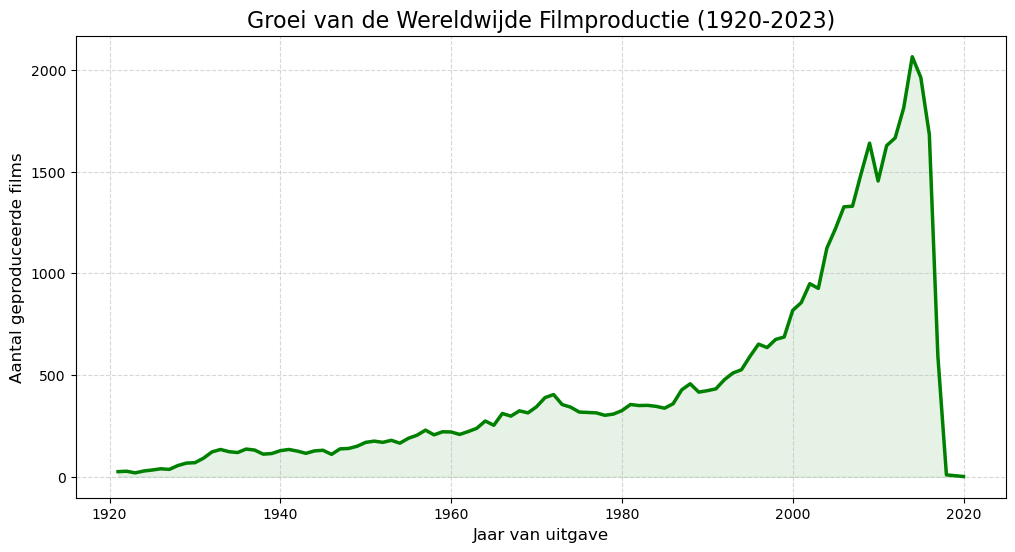

In [8]:
# 1. Data Aggregatie
# We tellen hoeveel films er per jaar zijn uitgebracht
timeline_df = df_enriched.groupBy("release_year") \
    .count() \
    .orderBy("release_year") \
    .toPandas()

# 2. Data Cleaning voor de plot
# We filteren jaartallen eruit die onlogisch zijn (toekomst of héél oud) voor een schone grafiek
timeline_df = timeline_df[(timeline_df['release_year'] > 1920) & (timeline_df['release_year'] < 2024)]

# 3. Visualisatie
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=timeline_df, 
    x="release_year", 
    y="count", 
    color="green", 
    linewidth=2.5
)

# Opmaak
plt.title("Groei van de Wereldwijde Filmproductie (1920-2023)", fontsize=16)
plt.xlabel("Jaar van uitgave", fontsize=12)
plt.ylabel("Aantal geproduceerde films", fontsize=12)
plt.fill_between(timeline_df['release_year'], timeline_df['count'], color="green", alpha=0.1) # Schaduw effect
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()